Hello everyone! 
First thing first: Enjoying **Kaggle 2.0** after the **Kaggle eclipse**?   😝 Idk if it's just a feeling but it seems like browsing the Kaggle website is much faster. Anyways, today, we are going to deep dive into a few very interesting things. You must be wondering why I choose this dataset **again**? The thing is that this dataset has some nice properties:<br>
* Highly imbalanced classes
* Healthcare -> Matters more than any other dataset
* Very few samples to train on and even fewer to validate on
* Literally hard to achieve a good combination of **precision** and **recall**

Before this, I made another [kernel](https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution) where I showed how **Depthwise Convolution** can beat other approaches. Today, I am going to beat that one as well. This notebook contains a lot of new information, from **tips and tricks** to a new **loss function**. Sit tight and read carefully!

In [1]:
import os
import cv2
import glob
import h5py
import shutil

import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout
from keras.layers import Input, Flatten, SeparableConv2D, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

from keras import backend as K
import tensorflow as tf


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

Using TensorFlow backend.


In [2]:
## I said it earlier as well, do everything you can to make your results reproducible. It matters!!

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [3]:
# Defining some paths..as usual!

# data path
data_dir = Path('../input/chest_xray/chest_xray')

# path to directory containing train set
train_dir = data_dir / 'train'

# path to directory containing validation set
val_dir = data_dir / 'val'

# path to the directory containing test set
test_dir = data_dir / 'test'

There are two classes in the dataset **Normal** and **Pneumonia** and for each class, we have some samples stored in the corresponding folder. We will store the names of these images and the corresponding label in a pandas dataframe to make life easy.

In [4]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_df.append((str(img),0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_df.append((str(img), 1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_df.head()

,image,label
0,../input/chest_xray/chest_xray/train/NORMAL/NO...,0
1,../input/chest_xray/chest_xray/train/NORMAL/NO...,0
2,../input/chest_xray/chest_xray/train/PNEUMONIA...,1
3,../input/chest_xray/chest_xray/train/PNEUMONIA...,1
4,../input/chest_xray/chest_xray/train/PNEUMONIA...,1


1    3875
0    1341
Name: label, dtype: int64


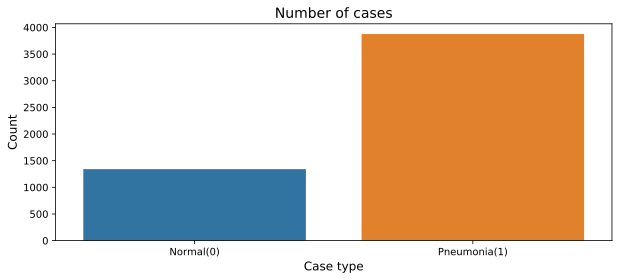

In [5]:
# Get the counts for each class
cases_count = train_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

You can see the imbalance between the classes here. The ratio is almost 1:3. Let us take a look at a few samples from each class. After all, visualization is an important part of any data pipeline and data modelling process

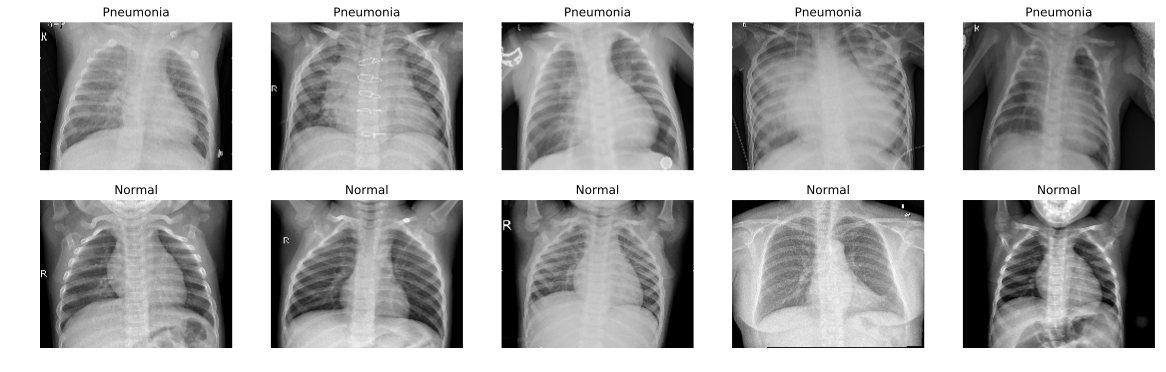

In [6]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(20,6))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

Next, we will define our **augmentations** that we are going to apply to the samples during the training process. At this point, I will stick to just two types of augmentations:
* Flip right
* Random rotation

In [7]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=30)]) # roatation

In [8]:
# some constants(not truly though!) 

# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3
# batch size for training  
batch_size=16

Define a training data generator.

In [9]:
def data_generator(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size,), dtype=np.float32)
    
    while True:
        # shuffle indices for the training data
        np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = seq.augment_image(img)
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                label = data.iloc[idx]["label"]
                
                batch_data[j] = img
                batch_labels[j] = label
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [10]:
# training data generator 
train_data_gen = data_generator(train_df, batch_size)

The **validation** set as well as the **test** set is very small. Hence we will load these two directly in the memory. This will be a one-time process but this will save a lot of time during the validation and testing process.

In [11]:
def read_images(images, label):
    """
    This function read images from a list of the given
    images. For each image it records a corresponding label.
    
    Args:
        images: list of all images
        label(int): label for these images
    
    Returns:
        data: numpy array containing pre-processed images. The pre-processing
              function is provided by keras
        labels: numpy array of corresponding labels
    """
    data = []
    for img in images:
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
        data.append(img)
    
    labels = [label]*len(data)
    data = np.array(data).astype(np.float32)
    data = preprocess_input(data)
    return data, labels

########################################################################################

def prepare_data(data_dir):
    """
    This function can be used to prepare the 
    validation and test datasets. 
    
    Args:
        data_dir: A pathlib object pointing to validation/test directory
    
    Returns:
        data: numpy array of all images
        labels: numpy array of corresponding labels
    """
    normal_cases_dir = data_dir / 'NORMAL'
    pneumonia_cases_dir = data_dir / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = list(normal_cases_dir.glob('*.jpeg'))
    pneumonia_cases = list(pneumonia_cases_dir.glob('*.jpeg'))
    print(f"Found {len(normal_cases)} normal cases and {len(pneumonia_cases)} pneumonia_cases")
    
    # process class-wise
    normal_cases_data, normal_cases_labels = read_images(normal_cases, 0)
    pneumonia_cases_data, pneumonia_cases_labels = read_images(pneumonia_cases, 1)
    
    # sanity-check
    assert len(normal_cases_data) == len(normal_cases_labels), "You had one job!"
    assert len(pneumonia_cases_data) == len(pneumonia_cases_labels), "You can't get it right, can you?"
    
    data = np.vstack((normal_cases_data, pneumonia_cases_data))
    labels = np.array((normal_cases_labels + pneumonia_cases_labels)).astype(np.float32)
    
    return data, labels

In [12]:
# Prepare validation data 
validation_data, validation_labels = prepare_data(val_dir)
print(f"Number of validation images: {len(validation_data)} and labels: {len(validation_labels)}")
print(validation_data.shape, validation_labels.shape)

Found 8 normal cases and 8 pneumonia_cases
Number of validation images: 16 and labels: 16
(16, 224, 224, 3) (16,)


In [13]:
# Prepare test data
test_data, test_labels = prepare_data(test_dir)
print("Number of samples in test data: ", len(test_data))
print(test_data.shape, test_labels.shape)

Found 234 normal cases and 390 pneumonia_cases
Number of samples in test data:  624
(624, 224, 224, 3) (624,)


You can see that we have only **16** samples in the validation set. This sample size is so small that getting good results on this doesn't necessarily mean that your model is good enough. Now, one might argue that you can simply switch **test** and **validation** set and get a bigger validation set. I would say that doing so is much worse than validating on small samples. Why? Becuase, in that case, your test set will be very small and taking that performance measure as a reference for validating goodness of model can turn out to be very bad.  

A good strategy would be to remove some samples from test set permanently and adding them in the validation set, For example, instead of having 624 samples, you can simply have 500 test samples and add the extra 124 samples to your validation set. I am not going to do it here but you can try later on.

For training, we will use **ResNet50** as our base model and we will do transfer learning on top of it. <br>
**Beware:**
* Freezing layers in any pre-trained network in Keras doesn't freeze all parts of a **BatchNormalization** layer. If your batch size is small, then it can be a huge problem as your validation loss will explode or your validation accuracy will be very low as compared to training accuracy. **This is not a typical overfitting case.** It's just that BN is messing with your training. In order to make sure that BN runs in **inference** mode, you have to set the learning phase as well.  
* Some people might say that the keras implementation of batch normalization is broken. I disagree with that completely. The training mode and inference mode is very different from any other. Hence *freezing the layer* has a different context when it comes to batch normalization. Check [this issue](https://github.com/keras-team/keras/pull/9965) for more details.

In [14]:
# Get fine-tuning/transfer-learning model
def get_fine_tuning_model(base_model, top_model, inputs, learning_type):
    if learning_type=='transfer_learning':
        print("Doing transfer learning")
        K.set_learning_phase(0)
        base_model.trainable = False
        features = base_model(inputs)
        outputs = top_model(features)
    else:
        print("Doing fine-tuning")
        base_model.trainable = True
        features = base_model(inputs)
        outputs = top_model(features)
    return Model(inputs, outputs)

In [15]:
# Get the base model
base_model = ResNet50(input_shape=(img_rows, img_cols, img_channels), 
                       weights='imagenet', 
                       include_top=False, 
                       pooling='avg')

94658560/94653016 [==============================] - 3s 0us/step


In [16]:
# Define a top model: extra layers that we are going to add on top of our base network
feature_inputs = Input(shape=base_model.output_shape, name='top_model_input')
x = Dense(50, activation='relu', name='fc1')(feature_inputs)
x = Dropout(0.5,name='drop')(x)
outputs = Dense(1, activation='sigmoid', name='fc2')(x)
top_model = Model(feature_inputs, outputs, name='top_model')

In [17]:
# get model for tranfser learning
inputs = Input(shape=(img_rows, img_cols, img_channels))
model = get_fine_tuning_model(base_model, top_model, inputs, "transfer_learning")
model.summary()

Doing transfer learning
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
top_model (Model)            multiple                  102501    
Total params: 23,690,213
Trainable params: 102,501
Non-trainable params: 23,587,712
_________________________________________________________________


We are going to define a new loss function today. **Focal loss** was first introduced in **[RetinaNet](https://arxiv.org/abs/1708.02002)**. This loss function is highly useful when you have highly imbalanced classes. I highly recommend reading that paper if you haven't got a chance yet.

In [18]:
# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [19]:
# compile the model and check it 
optimizer = RMSprop(0.0001)
model.compile(loss=focal_loss(), optimizer=optimizer, metrics=['accuracy'])

In [20]:
# always use earlystopping
# the restore_best_weights parameter load the weights of the best iteration once the training finishes
es = EarlyStopping(patience=5, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="model1", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(train_df)/batch_size))

# number of epochs 
nb_epochs=100

In [21]:
# train the model 
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=(validation_data, validation_labels),
                              callbacks=[es,chkpt],
                              class_weight={0:1.0, 1:0.33})

Epoch 1/100
326/326 [==============================] - 137s 420ms/step - loss: 0.0114 - acc: 0.8748 - val_loss: 0.0445 - val_acc: 0.9375
Epoch 2/100
326/326 [==============================] - 127s 390ms/step - loss: 0.0061 - acc: 0.9387 - val_loss: 0.0320 - val_acc: 0.9375
Epoch 3/100
326/326 [==============================] - 128s 391ms/step - loss: 0.0051 - acc: 0.9498 - val_loss: 0.0720 - val_acc: 0.8750
Epoch 4/100
326/326 [==============================] - 128s 392ms/step - loss: 0.0051 - acc: 0.9526 - val_loss: 0.0112 - val_acc: 0.9375
Epoch 5/100
326/326 [==============================] - 128s 391ms/step - loss: 0.0040 - acc: 0.9588 - val_loss: 0.0485 - val_acc: 0.8750
Epoch 6/100
326/326 [==============================] - 127s 390ms/step - loss: 0.0036 - acc: 0.9643 - val_loss: 0.0415 - val_acc: 0.9375
Epoch 7/100
326/326 [==============================] - 128s 394ms/step - loss: 0.0039 - acc: 0.9651 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 8/100
326/326 [====================

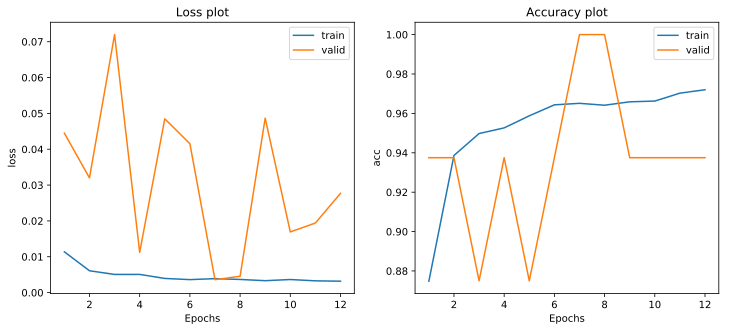

In [22]:
# plot the model loss and accuracy
train_loss = history1.history['loss']
train_acc = history1.history['acc']

valid_loss = history1.history['val_loss']
valid_acc = history1.history['val_acc']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

In [23]:
# evaluate on test set
test_loss, test_acc = model.evaluate(test_data, test_labels, batch_size=batch_size)
print("Test loss: ", test_loss)
print(f"Test set accuracy: {test_acc*100:.2f}%")

624/624 [==============================] - 5s 8ms/step
Test loss:  0.050439089918747924
Test set accuracy: 89.74%


In [24]:
# Get the predictions on test set
preds = model.predict(test_data, batch_size=16)
preds = np.squeeze((preds > 0.5).astype('int'))
orig = test_labels.astype('int')

<Figure size 432x288 with 0 Axes>

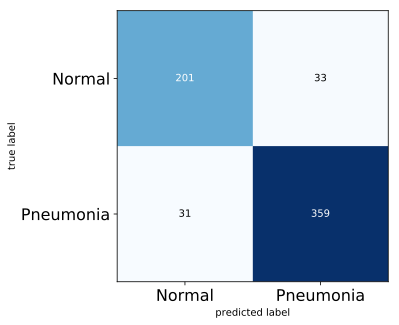

In [25]:
# Get the confusion matrix
cm  = confusion_matrix(orig, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,5), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [26]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.92
Precision of the model is 0.92


You can see that this is the **best** result achieved so far on this dataset. The model has a **high recall** as well as **very good** precision values. It is much better than my previous model(check for the link to the previous kernel at the top of the notebook)